# Data processing 

## Imports

In [45]:
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

## Functions

In [46]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
    
def tokenize(sentence):
    tokens = nltk.word_tokenize(sentence)
    return [w for w in tokens if not w.lower() in stop_words]


def stem(word):
    return stemmer.stem(word.lower())


def bag_of_words(tokenized_sentence, words):
    """
    return bag of words array:
    1 for each known word that exists in the sentence, 0 otherwise
    example:
    sentence = ["hello", "how", "are", "you"]
    words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
    bog   = [  0 ,    1 ,    0 ,   1 ,    0 ,    0 ,      0]
    """
    sentence_words = [stem(word) for word in tokenized_sentence]
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

## Load dataset

In [47]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

In [48]:
all_words = []
tags = []
xy = []

# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

In [49]:
# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]

# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

In [50]:
# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [51]:
class Sequences(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train
        
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]
    
    def __len__(self):
        return self.n_samples

# Model definition

## Hyperparameters

In [52]:
num_epochs = 400
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)

## Model

In [53]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

# Training

In [54]:
dataset = Sequences()

## Split data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    correct = 0
    correct_test = 0

    # Train loop
    for words, labels in train_loader:
        words = words.to(dtype=torch.float).to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, dim=1)
        correct += torch.sum(predicted == labels)
    
    train_accuracy = (100 * correct / len(train_dataset)).to('cpu')
    train_losses.append(loss.item())
    train_accs.append(train_accuracy)
    
    # Test loop
    for words, labels in test_loader:
        words = words.to(dtype=torch.float).to(device)
        labels = labels.to(dtype=torch.long).to(device)

        # Forward pass
        outputs = model(words)
        test_loss = criterion(outputs, labels)

        _, predicted_test = torch.max(outputs, dim=1)
        correct_test += torch.sum(predicted_test == labels)
    
    
    test_accuracy = (100 * correct_test / len(train_dataset)).to('cpu')
    test_losses.append(test_loss.item())
    test_accs.append(test_accuracy)
    
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}]')       
        print (f'(Train) Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')
        print (f'(Test) Loss: {test_loss.item():.4f}, Accuracy: {test_accuracy:.4f}')
        print('')

Epoch [100/400]
(Train) Loss: 0.7745, Accuracy: 89.8305
(Test) Loss: 0.5940, Accuracy: 20.3390

Epoch [200/400]
(Train) Loss: 0.3220, Accuracy: 98.3051
(Test) Loss: 0.2670, Accuracy: 23.7288

Epoch [300/400]
(Train) Loss: 0.0049, Accuracy: 98.3051
(Test) Loss: 0.2397, Accuracy: 23.7288

Epoch [400/400]
(Train) Loss: 0.0011, Accuracy: 98.3051
(Test) Loss: 0.2548, Accuracy: 22.0339



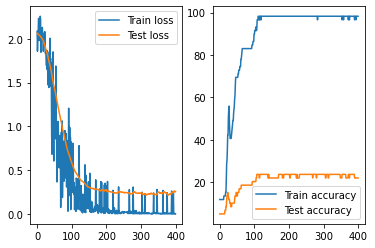

In [56]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend()

plt.show()

# Save model

In [81]:
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "model.pth"
torch.save(data, FILE)